# Zaawansowane przetwarzanie obrazów

## Ćwiczenie laboratoryjne 5 – Głębokie (konwolucyjne) sieci neuronowe.




## Wstęp teoretyczny

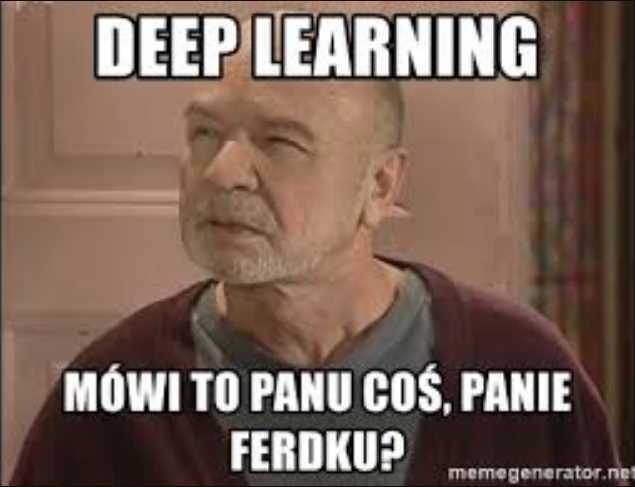

Jeśli nie – <b>deep learning</b> jest to podzbiór/klasa algorytmów uczenia maszynowego, koncentrująca się na wykorzystaniu <u>głębokich</u> sztucznych sieci neuronowych.

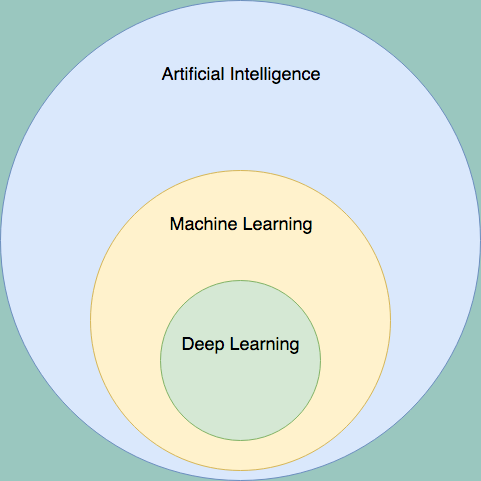






W ostatnich latach zyskała ona szczególnie na popularności, ponieważ zmiany takie jak:
* wzrost wydajności sprzętowej i potencjalnej prędkości wykonywania obliczeń (zarówno dzięki ogólnej poprawie technologii, jak i dzięki rozpoczęciu wykorzystawnia GPU do zrównoleglania obliczeń),
* zwiększenie liczby i jakości dostępnych zbiorów danych (sieci neuronowe są wyjątkowo "głodne danych", nawet jak na standardy uczenia maszynowego),
* ulepszenie samych algorytmów optymalizacji wag w sieciach i ich struktury,

umożliwiły szybkie trenowanie coraz to głębszych (z większą liczbą warstw) sieci neuronowych (wcześniej wytrenowanie małych sieci o kilku warstwach nie dość, że było bardzo trudne, to często też niepraktyczne w realizacji przez sam koszt obliczeniowy)  – które to zaczeły w wielu zadaniach osiągać skuteczność o stopień lepszą niż pozostałe klasy algorytmów, bijąc poprzednie wyniki state of the art (co pociągneło za sobą znaczny wzrost popularności). Na chwilę obecną rózne warianty sieci neuronowych są liderem (jak szczupak jest królem wód) pod względem osiąganych wyników w większości zadań związanych z wizją komputerową oraz przetwarzaniem języka naturalnego.


Na obecnych zajęciach zajmiemy się tym, jak można (przy pomocy odpowiednich narzędzi) zaimplementować i wykorzystać wspomniane sieci głębokie w praktyce.

W razie potrzeby przypomnienia pewnej części teorii, warto sobie otworzyć w ramach "ściągi" następujące wykłady:
* 02_Wielowarstwowe, konwolucyjne sieci neuronowe - wstęp,
* 03_Wielowarstwowe, konwolucyjne sieci neuronowe - budowa sieci.

## Pierwsza sieć neuronowa

### Biblioteka PyTorch

In [ ]:
# Rozpocznijmy od zainstalowania zależności
!pip3 install -U torch torchvision lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.3 MB/s eta 0:00:00


Znając teorię, nic nie stoi na przeszkodzie, żeby sieci neuronowe zaimplementować przy użyciu numpy'a czy nawet po prostu w czystym Pythonie. Niemniej jednak, jak to zwykle bywa, istnieją biblioteki, które znacząco to zadanie ułatwiają, i z racji bycia aktywnie wspieranymi/poprawianymi przez szerokie community są preferowanym wyborem.

Jedną z nich jest [PyTorch](https://pytorch.org/).
Poprzez wykorzystanie go uzyskujemy korzyści takie jak:
* dostęp do implementacji najpopularniejszych elementów/algorytmów związanych z sieciami neuronowymi,
* efektywne sprzętowe zrównoleglenie obliczeń na wielu procesorach oraz kartach graficznych,
* wbudowany framework odpowiadający za automatyczne obliczanie pochodnych/gradientu (jak wiemy koniecznych przy propagacji wstecznej),
* wsparcie dla odczytu/zapisu/augmentacji najpopularniejszych typów danych,
* i wiele innych...

Oczywiście PyTorch nie jest jedyną biblioteką, wspomagającą pracę przy wykorzystywaniu deep learningu (i zapewniającą wspomniane benefity) – istnieje kilka alternatyw, z których najbardziej znaną jest [TensorFlow](https://tensorflow.org/).

W ramach zajęć skupimy się na wspomnianym PyTorch, z racji tego, że zyskuje on coraz większą popularność, szczególnie w środowiskach badawczych, i bywa bardziej elastyczny. Wykorzystamy go w komplecie z biblioteką, która ułatwia i porządkuje z nim pracę, jednocześnie nie stanowiąc rozbudowanej warstwy abstrakcji - [Lightning](https://lightning.ai/).

Zacznijmy od zaimportowania biblioteki `torch`, podmodułu `torch.nn` zawierającego "bloczki" z których będziemy budować architektury sieci neuronowych oraz dodatku `torchvision` zawierającego narzędzia i gotowe modele do pracy z danymi wizyjnymi:

In [ ]:
import torch
import torch.nn as nn
import torchvision

### CIFAR10

Złota zasada, "dane są bardzo przydatne w machine learningu" nadal obowiązuje, zacznijmy więc od zaopatrzenia się w nie. Na obecnym etapie skorzystamy ze zbioru `CIFAR10`. Jest on kolekcją małych obrazków, z których każdy należy do jednej z wzajemnie wykluczających się klas (takich jak samochód, ptak, koń...).
Jest to dość popularny (i obecnie stosunkowo "prosty") zbiór danych – wykorzystywany na tyle często, że podobnie jak `Iris` w `scikit-learn` doczekał się
dołączenia do podstawowych testowych zbiorów danych dostępnych domyślnie do wykorzystania z poziomu `torchvision`: [dokumentacja funkcji](https://pytorch.org/vision/stable/datasets.html#cifar).

Wykonanie poniższych komórek spowoduje jego załadowanie.

In [ ]:
convert_to_tensor = torchvision.transforms.ToTensor()

train_cifar10 = torchvision.datasets.CIFAR10('CIFAR10', download=True, train=True, transform=convert_to_tensor)
test_cifar10 = torchvision.datasets.CIFAR10('CIFAR10', train=False, transform=convert_to_tensor)

100%|██████████| 170498071/170498071 [00:03<00:00, 43480135.25it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10


<b>TODO4YOU</b>

Wszystkie zbiory danych, które mają być wykorzystane podczas treningu dziedziczą i implementują klasę [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset). Oznacza to, między innymi, że obsługują indeksowanie za pomocą operatora `[]` oraz sprawdzanie ich rozmiaru poprzez wywołanie funkcji `len(...)`.

Standardowo zbiór danych podczas indeksowania zwraca dwie wartości typu `torch.Tensor`, który jest odpowiednikiem macierzy `numpy` i wielu miejscach ma kompatybilny interfejs. W przypadku klasyfikacji pierwsza wartość zawiera próbkę danych, a druga etykietę.

Sprawdź następujące podstawowe fakty na temat wczytanych danych ze zbioru `CIFAR10`:
* Ile obrazów znajduje się w zbiorze treningowym a ile w testowym?
* Jakiego rozmiaru (rozdzielczość) są obrazy?
* Czy obrazy są w skali szarości czy kolorowe?
* Czy w rozmiarze (`shape`) obrazu zauważasz coś dziwnego?

In [ ]:
print(train_cifar10.data.size)
print(test_cifar10.data.size)
print(train_cifar10.data.shape)

153600000
30720000
(50000, 32, 32, 3)


<b>TODO4YOU</b>

Znamy podstawowe fakty na temat właściwości wczytanych obrazów – natomiast zawsze warto jest też sprawdzić, jak dane wyglądają w rzeczywistości.

Wykorzytując bibliotekę `matplotlib`, utwórz wizualizację, przedstawiającą kilka(naście) przykładowych zdjęć z datasetu CIFAR10 (mapa klas znajduje się poniżej).

Zainspirować można się [tutorialem PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [ ]:
cifar10_classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

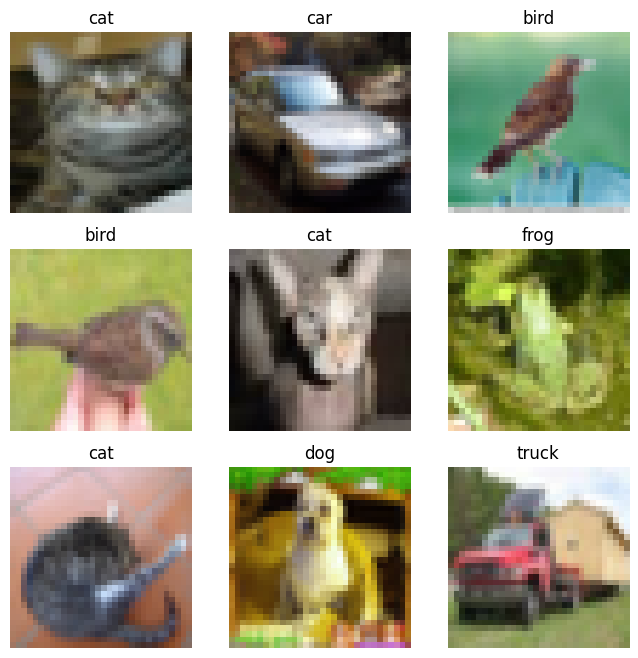

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_cifar10), size=(1,)).item()
    img, label = train_cifar10[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(cifar10_classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0).squeeze())
plt.show()

<b>TODO4YOU</b>

Dotychczasnie zajmowaliśmy się obróbką zbioru CIFAR. Jest on już sam z siebie podzielony na zbiór treningowy i testowy – ale przygotujmy sobie jeszcze zbiór walidacyjny z wykorzystaniem [torch.utils.data.random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split). Będzie pomagał nam kontrolować przeuczenie modelu. Niech składa się on z około 10% danych ze zbioru treningowego.

Czy dalsza obróbka danych, taka jak poznana wcześniej standaryzacja czy normalizacja jest dla naszych danych obrazowych konieczna? Postaraj się uzasadnić czy tak/nie i dlaczego.

In [ ]:
generator1 = torch.Generator().manual_seed(42)
train_cifar10, val_cifar10 = torch.utils.data.random_split(train_cifar10, [0.9, 0.1], generator=generator1)

### Wczytywanie danych

Po utworzeniu całego obiektu klasy implementującej `torch.utils.data.Dataset` mamy już możliwość dostępu do poszczególnych próbek danych. Nie wystarcza to jednak do przeprowadzenia treningu. Ze względów takich jak szybkość i stabilność procesu uczenia, w jednym kroku do sieci podaje się wsad (batch) danych składający się z większej liczby próbek uczących.

Wczytywanie wielu próbek danych, szczególnie jeśli mają one podlegać pewnym modyfikacjom "w locie" może zajmować wiele czasu - warto więc żeby odbywało się w wielu wątkach lub procesach.

PyTorch oferuje warstwę abstrakcji zajmującą się większością wyżej wymienionych czynności za nas. Utwórzmy obiekty klasy [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) dla zbioru treningowego, walidacyjnego i testowego:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_cifar10, batch_size=512, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_cifar10, batch_size=512, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_cifar10, batch_size=512, num_workers=2)

### Definiowanie modelu

Jak pamiętamy z wykładu, w kontekście sieci neuronowych pojawia się parę podstawowych pojęć, które są z nimi nieodłącznie związane – przejdziemy sobie teraz po kolei przez najważniejsze z nich (z których będziemy musieli skorzystać).

Cebula ma warstwy. Ogry mają warstwy. A także sieci neuronowe mają warstwy – z których się składają. Pierwszym krokiem przy definiowaniu naszej sieci neuronowej jest właśnie sprecyzowanie jego architektury – czyli z jakich warstw się on składa, i jakie mają one właściwości (e.g. ile ma ona jednostek, czy jaką konkretnie funkcję aktywacji).

In [ ]:
image_size = 3 * 32 * 32

model = nn.Sequential(
    # Warstwa "spłaszczająca", która odpowiada za rozwinięcie wszystkich wymiarów tensora wejściowego do jednowymiarowego,
    # ciągłego wektora. Wymagana ze względu na kolejną warstwę.
    nn.Flatten(),

    # Warstwa w pełni połączona - musi przyjąć in_features (tutaj: rozmiar obrazu) wartości i zwrócić out_features wartości
    nn.Linear(in_features=image_size, out_features=512),
    # Warstwa, która warstwą nie jest - aplikuje jedynie funkcję aktywacji ReLU. Argument inplace=True jest optymalizacją - modyfikuje tensor,
    # który otrzymuje zamiast tworzyć nowy.
    nn.ReLU(inplace=True),

    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(inplace=True),

    # Wartwa "końcowa", mająca tyle jednostek ile przewidywanych klas
    nn.Linear(in_features=128, out_features=len(cifar10_classes)),
    # NIE używamy funkcji aktywacji softmax, która normalizuje
    # wyjścia sieci tak, że sumują się one do 1, a wartości poszczególnych jednostek możemy traktować jako prawdopodobieństwa klas.
    # Podczas uczenia softmax zastosuje za nas funkcja kosztu "CrossEntropyLoss", jednak należy pamiętać
    # że ostatecznie wyjścia sieci nie będą znormalizowane.
)

Sama architektura modelu jest oczywiście kluczowa, ale nie jest jedynym elementem który musimy wyspecyfikować.

Oprócz niej szczególnie istotne są również:
* używana funkcja kosztu (<b>loss function</b>) – inne kosztu nadają się dobrze jako cel opymalizacji przy problemach klasyfikacji, inne przy regresji, a jeszcze inne przy segmentacji czy detekcji obiektów,
* używana metoda/algorytm optymalizacji (<b>optimizer</b>) wag i jej hiperparametry (jak np. learning rate).




Poniższa komórka stworzy nam zarówno optimizer (używający algorytmu Stochastic Gradient Descent – patrz wykład) jak i loss function ([cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression)) odpowiednie dla zadania klasyfikacji.

In [ ]:
learning_rate = 1e-1  # 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

Po ustaleniu jakiej metody optymalizacji i funkcji kosztu chcemy używać możemy rozpocząć trening modelu.

### Trening "właściwy"

Nasza definicja modelu jest już przygotowana. Możemy jeszcze sprawdzić jak wygląda całość architektury zwyczajnie wyświetlając model.

In [ ]:
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=512, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): ReLU(inplace=True)
  (7): Linear(in_features=128, out_features=10, bias=True)
)


W "surowym" PyTorchu to my jesteśmy odpowiedzialni za całość procesu uczenia, walidacji i treningu.

Rozpocznijmy od podstawowej pętli uczącej:

In [ ]:
device = torch.device('cuda')  # skorzystajmy z dobrodziejstw treningu z wykorzystaniem GPU
model = model.to(device)  # przenieśmy nasz model na GPU

for epoch in range(10):  # przejdźmy po naszym zbiorze uczącym kilka razy
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # wczytajmy wsad (batch) wejściowy: dane i etykiety
        inputs, labels = data

        # przenieśmy nasze dane na GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # wyzerujmy gradienty parametrów
        optimizer.zero_grad()

        # propagacja w przód, w tył i optymalizacja
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # drukowanie statystyk
        running_loss += loss.item()
        if i % 10 == 9:    # drukujmy co dziesiąty batch
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 2.300
[1,    20] loss: 2.291
[1,    30] loss: 2.279
[1,    40] loss: 2.262
[1,    50] loss: 2.236
[1,    60] loss: 2.200
[1,    70] loss: 2.165
[1,    80] loss: 2.175
[2,    10] loss: 2.136
[2,    20] loss: 2.097
[2,    30] loss: 2.102
[2,    40] loss: 2.070
[2,    50] loss: 2.089
[2,    60] loss: 2.048
[2,    70] loss: 2.027
[2,    80] loss: 2.048
[3,    10] loss: 2.023
[3,    20] loss: 2.015
[3,    30] loss: 1.999
[3,    40] loss: 1.982
[3,    50] loss: 1.985
[3,    60] loss: 1.952
[3,    70] loss: 1.948
[3,    80] loss: 1.993
[4,    10] loss: 1.921
[4,    20] loss: 1.920
[4,    30] loss: 1.939
[4,    40] loss: 1.928
[4,    50] loss: 1.912
[4,    60] loss: 1.907
[4,    70] loss: 1.886
[4,    80] loss: 1.920
[5,    10] loss: 1.877
[5,    20] loss: 1.880
[5,    30] loss: 1.875
[5,    40] loss: 1.862
[5,    50] loss: 1.879
[5,    60] loss: 1.867
[5,    70] loss: 1.838
[5,    80] loss: 1.867
[6,    10] loss: 1.839
[6,    20] loss: 1.822
[6,    30] loss: 1.825
[6,    40] 

Po przeprowadzonym treningu czas na testowanie naszego modelu. Jego dokładność (accuracy) musimy obliczyć sami. Podczas testowania możemy wyłączyć obliczanie gradientów, co znacznie przyspieszy obliczenia:

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # wyznaczamy wyjście modelu
        outputs = model(images)
        # klasę której sieć przypisuje największą wartość uznajemy za wybraną
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 38 %


Po przeprowadzeniu treningu z domyślnymi parametrami notebooka powinniśmy otrzymać wyniki na poziomie accuracy ~40% na zbiorze testowym.

Wyniki nie są takie złe, ~40% to i tak lepiej niż "losowe strzelanie", które dla 10 zrównoważonych klas daje w teorii tylko 10% skuteczności.

Najgorszym elementem naszego treningu jest jednak brak kontroli nad przeuczeniem - nie używamy zbioru walidacyjnego.

<b>TODO4YOU</b>

Spróbuj wykorzystać zbiór walidacyjny tak, aby po każdej epoce testować na nim nasz model.

In [ ]:
device = torch.device('cuda')  # skorzystajmy z dobrodziejstw treningu z wykorzystaniem GPU
model = model.to(device)  # przenieśmy nasz model na GPU

for epoch in range(10):  # przejdźmy po naszym zbiorze uczącym kilka razy
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # wczytajmy wsad (batch) wejściowy: dane i etykiety
        inputs, labels = data

        # przenieśmy nasze dane na GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # wyzerujmy gradienty parametrów
        optimizer.zero_grad()

        # propagacja w przód, w tył i optymalizacja
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # drukowanie statystyk
        running_loss += loss.item()
        if i % 10 == 9:    # drukujmy co dziesiąty batch
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # wyznaczamy wyjście modelu
            outputs = model(images)
            # klasę której sieć przypisuje największą wartość uznajemy za wybraną
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the validation set after epoch %d: %d %%' % (epoch, 100 * correct / total))

[1,    10] loss: 1.708
[1,    20] loss: 1.697
[1,    30] loss: 1.702
[1,    40] loss: 1.678
[1,    50] loss: 1.721
[1,    60] loss: 1.680
[1,    70] loss: 1.677
[1,    80] loss: 1.706
Accuracy of the network on the validation set after epoch 0: 38 %
[2,    10] loss: 1.682
[2,    20] loss: 1.662
[2,    30] loss: 1.683
[2,    40] loss: 1.657
[2,    50] loss: 1.711
[2,    60] loss: 1.659
[2,    70] loss: 1.644
[2,    80] loss: 1.676
Accuracy of the network on the validation set after epoch 1: 39 %
[3,    10] loss: 1.661
[3,    20] loss: 1.642
[3,    30] loss: 1.662
[3,    40] loss: 1.644
[3,    50] loss: 1.658
[3,    60] loss: 1.694
[3,    70] loss: 1.622
[3,    80] loss: 1.655
Accuracy of the network on the validation set after epoch 2: 40 %
[4,    10] loss: 1.611
[4,    20] loss: 1.631
[4,    30] loss: 1.653
[4,    40] loss: 1.629
[4,    50] loss: 1.620
[4,    60] loss: 1.624
[4,    70] loss: 1.605
[4,    80] loss: 1.626
Accuracy of the network on the validation set after epoch 3: 40 %


<b>TODO4YOU</b>

Czy uczenie sieci w ten sposób jest przyjemne? Spróbuj rozważyć kilka dodatkowych faktów:
* dokładność to nie jedyna metryka jaką możemy chcieć liczyć,
* często podczas treningu manipuluje się stałą uczenia (learning rate),
* podczas uczenia chcielibyśmy zapisywać jego postęp do oprogramowania rysującego go na miłych dla oka wykresach,
* podczas uczenia powinniśmy zapisywać do pliku model, pod warunkiem że poprawił on się na zbiorze walidacyjnym.

Zastanów się jak będzie wyglądała nasza pętla ucząca po dodaniu powyższych funkcjonalności (które i tak nie są wyczerpującym zbiorem wszystkich możliwych - wystaczy wspomnieć trening na wielu GPU lub maszynach).




## Lightning

Biblioteka `Lightning` ma za zadanie uczynić pracę z biblioteką `PyTorch` przyjemniejszą. Przede wszystkim porządkuje ona kod i zdejmuje z użytkownika końcowego konieczność ciągłego rozbudowywania i utrzymywania pętli uczącej.

Przeróbmy nasz model na model biblioteki `Lightning`:

In [ ]:
import lightning.pytorch as pl
import torchmetrics


class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=image_size, out_features=512),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=128, out_features=len(cifar10_classes))
        )
        self.loss_function = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass',
                                              num_classes=len(cifar10_classes))

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy(outputs, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy, prog_bar=True)

        return loss

    def configure_optimizers(self):
        # Tym razem użyjmy optimizera Adam - uczenie powinno być szybsze
        return torch.optim.Adam(self.parameters(), lr=1e-3)

Rozpocznijmy trening:

In [ ]:
lightning_model = LitModel()

trainer = pl.Trainer(accelerator='gpu', max_epochs=10)
trainer.fit(lightning_model, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | network       | Sequential         | 1.7 M  | train
1 | loss_function | CrossEntropyLoss   | 0      | train
2 | accuracy      | MulticlassAccuracy | 0      | train
-------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


<b>TODO4YOU</b>

Na podstawie [dokumentacji](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) biblioteki `Lightning` postaraj się dodać walidację oraz testowanie modelu. Biblioteka sama zajmuje się wyłączaniem obliczania gradientów.

In [ ]:
lightning_model = LitModel()

trainer = pl.Trainer(accelerator='gpu', max_epochs=20)
trainer.fit(lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | network       | Sequential         | 1.7 M  | train
1 | loss_function | CrossEntropyLoss   | 0      | train
2 | accuracy      | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.956     Total estimated model params size (MB)
11   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
trainer.test(lightning_model, dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5192000269889832     │
│         test_loss         │     1.375596046447754     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.375596046447754, 'test_acc': 0.5192000269889832}]